In [4]:
import tensorflow as tf
import math
import random
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import os

In [12]:
#reading dataset
image_size = 100
images=[]
labels=[]
classes=['Bank_Post_office','Not_Bank_post_office']
num_classes=len(classes)
print('Going to read training images')
for fields in classes:   
    index = classes.index(fields)
    print('Now going to read {} files (Index: {})'.format(fields, index))
    path = os.path.join("ml_train_path", fields, '*g')
    files = glob.glob(path)
    for fl in files:
        image = cv2.imread(fl)
        image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        label = np.zeros(len(classes))
        label[index] = 1.0
        labels.append(label)
images = np.array(images)
labels = np.array(labels)

Going to read training images
Now going to read Bank_Post_office files (Index: 0)
Now going to read Not_Bank_post_office files (Index: 1)


In [20]:
session = tf.Session()
num_channels = 3
#photo holder
x = tf.placeholder(tf.float32, shape=[None, image_size,image_size,num_channels], name='x')

#label holder
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

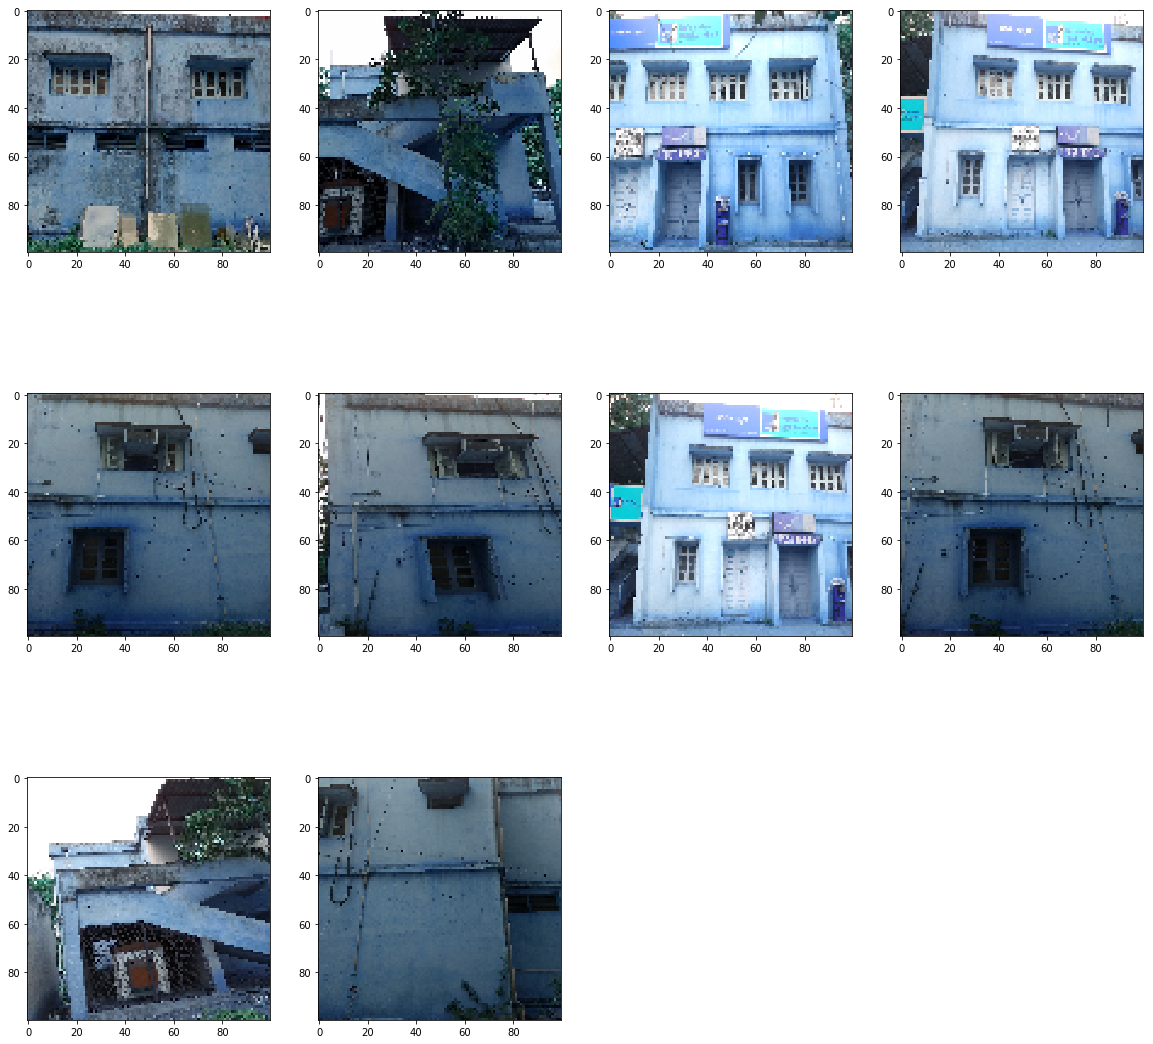

In [21]:
#printing dataset
plt.figure(figsize=(20,20))
columns = 4
for i in range(10):
    plt.subplot(10 / columns + 1, columns, i + 1)
    plt.imshow(images[i,:,:,:])
plt.show()   

In [22]:
#------------------------------------------First Convolution Layer----------------------------------------------------

W=tf.Variable(tf.random_normal([5, 5, 3, 32]))       # using 32 filters of 5x5 each having dimension 3    
b=tf.Variable(tf.random_normal([32]))                # 1x32 bais values  

x2 = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') 
x2 = tf.nn.bias_add(x2, b)
conv_output=tf.nn.relu(x2)
maxpool_output=tf.nn.max_pool(conv_output,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#new image size 50x50

In [23]:
#------------------------------------------Second Convolution Layer----------------------------------------------------

W1=tf.Variable(tf.random_normal([3, 3, 32, 64]))  # using 64 filters of 3x3 each having dimension of 32  
b1=tf.Variable(tf.random_normal([64]))            # 64 bais values

x3 = tf.nn.conv2d(maxpool_output, W1, strides=[1, 1, 1, 1], padding='SAME')
x3 = tf.nn.bias_add(x3, b1)
conv_output2=tf.nn.relu(x3)
maxpool_output2=tf.nn.max_pool(conv_output2,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#new image size 25x25

In [24]:
#-------------------------------------------Third Convolution Layer---------------------------------------------------

W2=tf.Variable(tf.random_normal([3, 3, 64,16]))  # using 16 filters of 3x3 each having dimension of 16 
b2=tf.Variable(tf.random_normal([16]))

x4 = tf.nn.conv2d(maxpool_output2, W2, strides=[1, 1, 1, 1], padding='SAME')
x4 = tf.nn.bias_add(x4, b2)
conv_output3=tf.nn.relu(x4)
maxpool_output3=tf.nn.max_pool(conv_output3,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#new image size 13x13

In [29]:
#-------------------------------------------Fully Connected Network---------------------------------------------------


fc_weights1=tf.Variable(tf.truncated_normal([13*13*16, 1024],stddev=0.05))  #   13*13*16(2704) input features 
fc_bias1=tf.Variable(tf.random_normal([1024]))  # 1024 bias   

fc_weights2=tf.Variable(tf.random_normal([1024, 2048]))      # Hidden Layer accept 1024 
fc_bias2=tf.Variable(tf.random_normal([2048]))               #2048 bias

fc_weights3=tf.Variable(tf.random_normal([2048, 128]))       
fc_bias3=tf.Variable(tf.random_normal([128]))

fc_weights4=tf.Variable(tf.random_normal([128, 8]))
fc_bias4=tf.Variable(tf.random_normal([8]))

fc_weights5=tf.Variable(tf.random_normal([8,2]))
fc_bias5=tf.Variable(tf.random_normal([2]))

In [30]:
fc1 = tf.reshape(maxpool_output3, [-1, fc_weights1.get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, fc_weights1), fc_bias1)
fc1 = tf.nn.sigmoid(fc1)


fcl2 = tf.add(tf.matmul(fc1, fc_weights2), fc_bias2)
fcl2=tf.nn.sigmoid(fcl2)


fcl3 = tf.add(tf.matmul(fcl2, fc_weights3), fc_bias3)
fcl3=tf.nn.sigmoid(fcl3)


fcl4 = tf.add(tf.matmul(fcl3, fc_weights4), fc_bias4)
fcl4=tf.nn.sigmoid(fcl4)

In [33]:
#output prediction
out = tf.add(tf.matmul(fcl4, fc_weights5), fc_bias5)
y_pred = tf.nn.sigmoid(out,name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)

cost = tf.reduce_mean(( (labels * tf.log(y_pred)) + ((1 - labels) * tf.log(1.0 - y_pred)) ) * -1)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [34]:
#accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [35]:
session.run(tf.global_variables_initializer()) 

In [39]:
def show_progress(epoch, feed_dict_train,val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    #val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%},Loss: {2:.3f}"
    print(msg.format(epoch + 1, acc,val_loss))

In [42]:
saver = tf.train.Saver()
for i in range(1000):
    feed_dict_tr = {x:images,y_true:labels}
    res,train_=session.run([cost,train_step],feed_dict_tr)
    if i%10 == 0:
        show_progress(i,feed_dict_tr,res)
        saver.save(session,'bank-model')

Training Epoch 1 --- Training Accuracy:  99.3%,Loss: 0.364
Training Epoch 11 --- Training Accuracy:  99.3%,Loss: 0.342
Training Epoch 21 --- Training Accuracy:  99.7%,Loss: 0.321
Training Epoch 31 --- Training Accuracy:  99.7%,Loss: 0.303
Training Epoch 41 --- Training Accuracy:  99.7%,Loss: 0.287
Training Epoch 51 --- Training Accuracy:  99.7%,Loss: 0.272
Training Epoch 61 --- Training Accuracy:  99.7%,Loss: 0.258
Training Epoch 71 --- Training Accuracy:  99.7%,Loss: 0.246
Training Epoch 81 --- Training Accuracy:  99.8%,Loss: 0.235
Training Epoch 91 --- Training Accuracy:  99.7%,Loss: 0.224
Training Epoch 101 --- Training Accuracy:  99.7%,Loss: 0.215
Training Epoch 111 --- Training Accuracy:  99.7%,Loss: 0.206
Training Epoch 121 --- Training Accuracy:  99.7%,Loss: 0.198
Training Epoch 131 --- Training Accuracy:  99.7%,Loss: 0.190
Training Epoch 141 --- Training Accuracy:  99.7%,Loss: 0.183
Training Epoch 151 --- Training Accuracy:  99.7%,Loss: 0.177
Training Epoch 161 --- Training Acc

KeyboardInterrupt: 